# Analysis on correlation between earthquakes and surface mass loading

In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

In [4]:
# import sys
# !{sys.executable} -m pip install netcdf4

### 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [5]:
# GRACE data
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [6]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [7]:
depth = cat['depth']
catalog['depth'] = depth

catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0,10.00
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0,0.00
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0,34.46
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0,33.00
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0,80.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0,33.00
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0,33.00
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0,62.00
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0,10.00


### 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [8]:
etas_declustered = catalog[catalog['P_triggered']<.9]
etas_declustered.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth
8069,8071,-38.9580,-15.7050,2009-01-19 10:27:12.440,5.4,POINT (-38.958 -15.705),5.4,0.0,6.907373e-11,0.571877,0.428123,1.0,10.00
4751,4753,36.5757,86.8448,2013-11-23 23:30:42.550,5.4,POINT (36.5757 86.84480000000001),5.4,0.0,6.907373e-11,0.719846,0.280154,1.0,7.18
4814,4816,35.7595,77.4189,2013-10-20 19:45:07.850,5.4,POINT (35.7595 77.41889999999999),5.4,0.0,6.907373e-11,0.895235,0.104765,1.0,96.76
11524,11526,-22.8750,-63.6460,2004-01-13 21:54:23.440,5.4,POINT (-22.875 -63.646),5.4,0.0,6.907373e-11,0.818147,0.181853,1.0,535.30
2864,2866,-57.0938,-150.6143,2017-02-11 04:27:59.940,5.4,POINT (-57.0938 -150.6143),5.4,0.0,6.907373e-11,0.791544,0.208456,1.0,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,3446,-4.9521,94.3299,2016-03-02 12:49:48.110,7.8,POINT (-4.9521 94.32989999999999),5.4,0.0,6.907373e-11,0.633045,0.366955,1.0,24.00
3937,3939,28.2305,84.7314,2015-04-25 06:11:25.950,7.8,POINT (28.2305 84.73139999999999),5.4,0.0,6.907373e-11,0.613225,0.386775,1.0,8.22
8514,8516,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),5.4,0.0,6.907373e-11,0.307076,0.692924,1.0,19.00
2402,2404,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),5.4,0.0,6.907373e-11,0.794144,0.205856,1.0,14.06


In [9]:
# etas_declustered.to_csv('ETAS-catalog.csv')

### 3. Add surface load data to the earthquake dataframes

In [10]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
etas_declustered['dmass'] = etas_declustered.apply(lambda row: get_mass(row), axis=1)
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with earthquakes that have low probability of being triggered?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because the declustered catalog are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [11]:
print('ETAS declustered mean:   %f'%etas_declustered['dmass'].mean())
print('ETAS declustered median: %f'%etas_declustered['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

ETAS declustered mean:   0.441004
ETAS declustered median: 0.284740
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


### 4. Analyze correlation between all events and surface mass loading

In [12]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics:
    
- CramerVonMisesResult(statistic=18.386893296385097, pvalue=3.1430320568404113e-09),
- KstestResult(statistic=0.05779103923331644, pvalue=6.212789284386416e-37),
- 'median_all': 0.749170696239575,
- 'median_eq': array(1.05422887),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.8274112789242835,
- 'mean_all_minus_mean_eq': -1.4812864573380033,
- 'median_all_minus_median_eq': -0.30505817015141257}

In [13]:
importlib.reload(loadquakes)

def set_of_figures_load(all_time, earthquake_only,bayes_title,method):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,14))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'a. Cumulative Distribution', 'b. Probability Density', method)

    loadquakes.plot_bayes(all_time, earthquake_only, ax3, bayes_title,
                         method)

    fig.tight_layout()

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


402


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


402
401


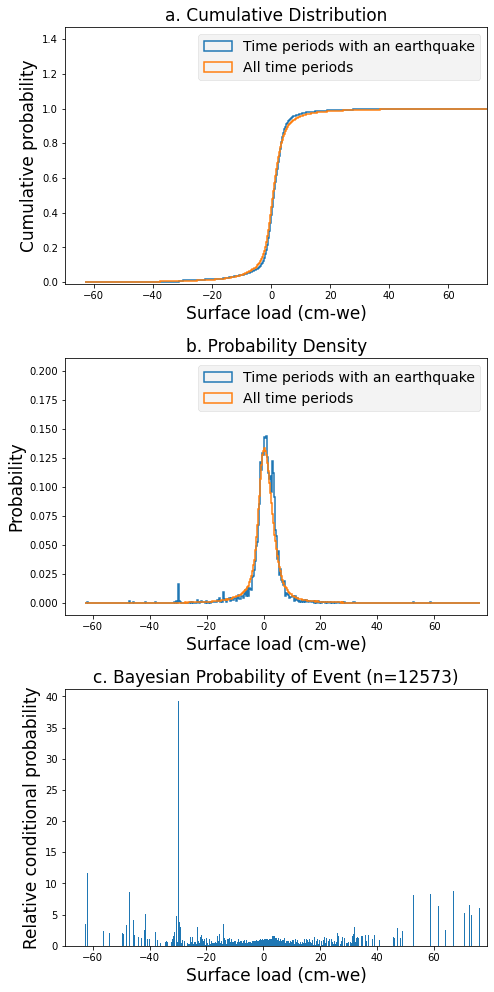

In [14]:
set_of_figures_load(ds['lwe_thickness'].data.flatten(), catalog.dmass,
                    'c. Bayesian Probability of Event (n=12573)','fd')

## 5. Correlation between ETAS declustered catalog and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of surface mass load during earthquake occurrence is significantly different from background.

In [15]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)
# loadquakes.calc_stats(np.array(etas_declustered.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics

- 'cvm': CramerVonMisesResult(statistic=18.38713838188511, pvalue=3.178242002910281e-09),
- 'ks': KstestResult(statistic=0.0833189806824356, pvalue=0.0010844083570850202),
- 'median_all': 0.749170696239575,
- 'median_eq': array(0.2847398),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.44100372833838036,
- 'mean_all_minus_mean_eq': -1.0948789067521003,
- 'median_all_minus_median_eq': 0.46443089594810544}

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


71


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


71
70


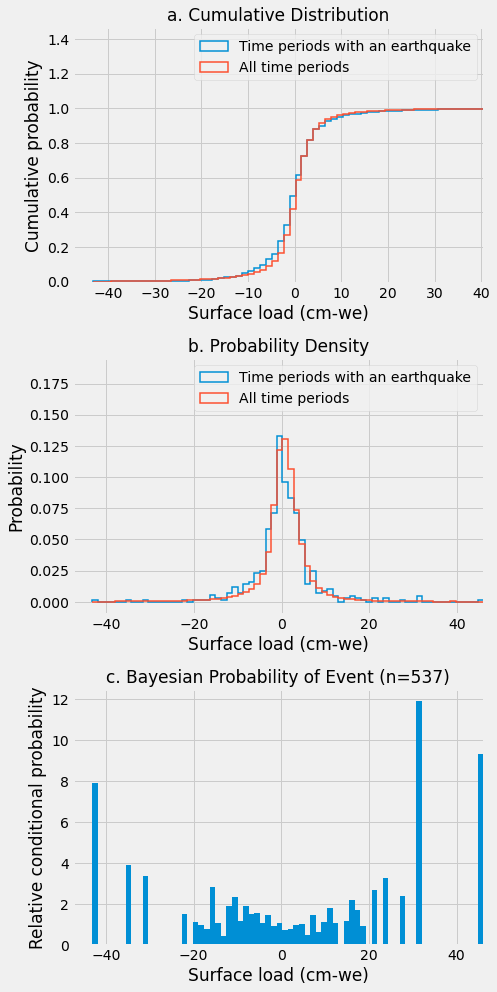

In [16]:
importlib.reload(loadquakes)

set_of_figures_load(ds['lwe_thickness'].data.flatten(), etas_declustered.dmass,
                    'c. Bayesian Probability of Event (n=537)','fd')

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


21
20


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


71
70


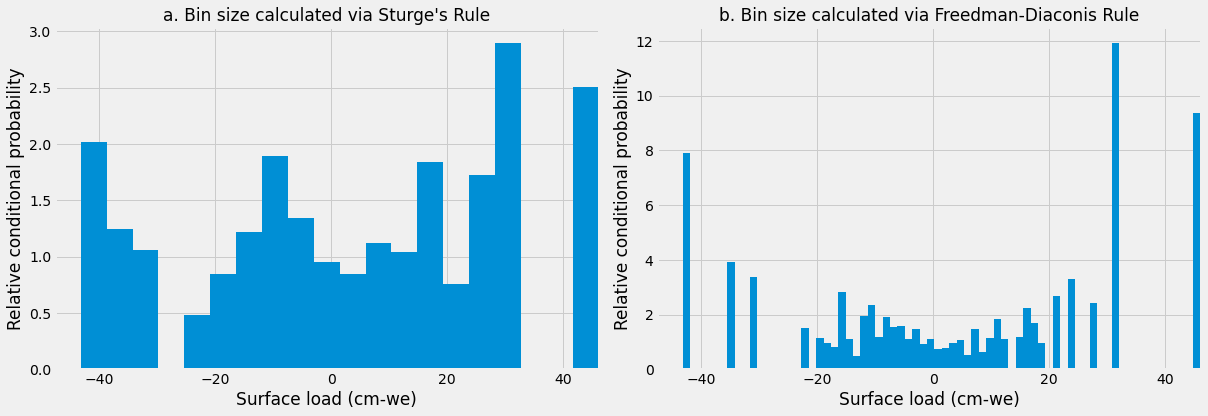

In [17]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), etas_declustered.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method='Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), etas_declustered.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method='fd')

fig.tight_layout()


## 6. Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each event

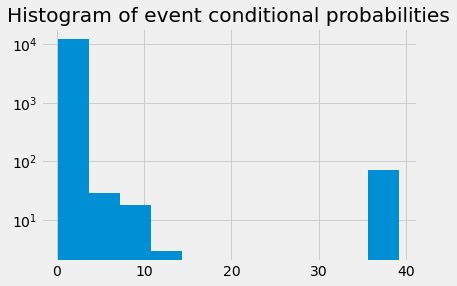

In [19]:
# Full catalog 

conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(catalog.dmass), np.array(catalog.dmass), 'fd')
catalog['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(catalog['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


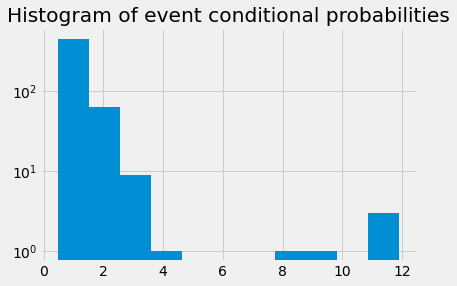

In [20]:
# ETAS declustered

conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(etas_declustered.dmass), np.array(etas_declustered.dmass), 'fd')
etas_declustered['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(etas_declustered['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

In [21]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0,10.00,4.971506058424656,0.939436
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0,0.00,2.485465024590889,1.146643
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0,34.46,0.5277498589169527,1.068970
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0,33.00,0.5277498589169527,1.068970
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0,80.00,2.113893922464259,1.031600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0,33.00,-1.6499232850367236,0.830483
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0,33.00,-2.669668663359428,0.792210
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0,62.00,-1.9343003050948298,0.788454
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0,10.00,-2.905379948482504,0.762105


In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

def probability_map_cb(events,color,mag_legend,label,vmin,vmax,markersize_scale):

    gdf=gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("bottom", size="5%", pad=0.6)
    
    # plotting all events in tiny grey dots
    ax.scatter(catalog.longitude,catalog.latitude,c="darkgrey",marker=".")
    
    for i in mag_legend:
#     for i in events.index:
        ax.scatter(events.longitude.loc[i],
                   events.latitude.loc[i], 
                   c="darkgrey", 
                   s=1e-5*(events.magnitude.loc[i])**(markersize_scale),
                   label=np.round_(events.magnitude,1).loc[i],
                   edgecolor='k')

    cmap = cm.get_cmap('viridis', 11) # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize=1e-5*(events.magnitude)**markersize_scale,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=vmax,
            vmin=vmin)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize=1e-5*(events.magnitude)**markersize_scale)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    
    ax.legend(scatterpoints=1,
       loc='upper left',
       ncol=1,
       fontsize=12,
       labelspacing=5)

### Plotting the 10 SLIQs from the full catalog with highest CP

In [75]:
sliq_full=catalog.sort_values('cp',ascending=False)
sliq_full=sliq_full.reset_index()
sliq_full=sliq_full.drop(['index'], axis=1)

sliq_full

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,6584,37.5620,142.8550,2011-03-11 06:55:33.600,5.9,POINT (37.562 142.855),5.4,0.0,6.907373e-11,1.000000,3.092319e-07,1.0,39.80,-29.597742889705952,39.230289
1,6553,37.5690,142.8230,2011-03-11 08:06:20.680,5.4,POINT (37.569 142.823),5.4,0.0,6.907373e-11,1.000000,1.408214e-07,1.0,20.80,-29.597742889705952,39.230289
2,6633,38.4350,142.8420,2011-03-09 02:45:20.330,7.3,POINT (38.435 142.842),5.4,0.0,6.907373e-11,0.999751,2.490565e-04,1.0,32.00,-29.597742889705952,39.230289
3,6432,37.7670,142.7830,2011-03-13 14:48:01.360,5.4,POINT (37.767 142.783),5.4,0.0,6.907373e-11,0.999999,1.153830e-06,1.0,17.90,-29.597742889705952,39.230289
4,6541,37.6400,142.7710,2011-03-11 08:39:12.960,5.5,POINT (37.64 142.771),5.4,0.0,6.907373e-11,1.000000,1.114348e-07,1.0,46.20,-29.597742889705952,39.230289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,4307,27.1891,103.4086,2014-08-03 08:30:13.570,6.2,POINT (27.1891 103.4086),5.4,0.0,6.907373e-11,0.976347,2.365326e-02,1.0,12.00,20.876495237940105,0.206827
12569,3729,40.9329,47.5328,2015-09-04 04:49:38.520,5.4,POINT (40.9329 47.5328),5.4,0.0,6.907373e-11,0.981027,1.897288e-02,1.0,13.96,-20.384058704314988,0.185497
12570,9206,20.5030,100.7320,2007-05-16 08:56:14.120,6.3,POINT (20.503 100.732),5.4,0.0,6.907373e-11,0.636321,3.636793e-01,1.0,9.00,-19.483535464303685,0.181464
12571,6351,1.6120,97.0860,2011-04-06 14:01:42.560,6.0,POINT (1.612 97.086),5.4,0.0,6.907373e-11,0.999741,2.591134e-04,1.0,20.00,17.753596834348716,0.144856


### Plotting the 10 SLIQs from the ETAS declustered catalog with highest CP

In [76]:
sliq_etas=etas_declustered.sort_values('cp',ascending=False)
sliq_etas=sliq_etas.reset_index()
sliq_etas=sliq_etas.drop(['index'], axis=1)

sliq_etas

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,10468,28.8810,94.6260,2005-06-01 20:06:41.450,5.8,POINT (28.881 94.626),5.4,0.0,6.907373e-11,0.796710,0.203290,1.0,25.80,31.35207431117368,11.914214
1,11828,29.5730,95.6050,2003-08-18 09:03:03.520,5.5,POINT (29.573 95.605),5.4,0.0,6.907373e-11,0.585476,0.414524,1.0,33.00,31.84687742437117,11.914214
2,11864,22.8540,92.3060,2003-07-26 23:18:17.960,5.7,POINT (22.854 92.306),5.4,0.0,6.907373e-11,0.891394,0.108606,1.0,10.00,31.68322316970908,11.914214
3,3127,-1.0355,31.6181,2016-09-10 12:27:33.410,5.9,POINT (-1.0355 31.6181),5.4,0.0,6.907373e-11,0.470086,0.529914,1.0,40.00,45.98749350911166,9.359505
4,4412,40.3731,51.5739,2014-06-07 06:05:29.910,5.5,POINT (40.3731 51.5739),5.4,0.0,6.907373e-11,0.792073,0.207927,1.0,30.51,-43.05570164414012,7.904443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,11181,-6.2420,95.6660,2004-08-07 14:18:35.240,5.6,POINT (-6.242 95.666),5.4,0.0,6.907373e-11,0.817903,0.182097,1.0,20.70,5.931310290998125,0.512514
533,957,-22.7578,-112.3155,2020-08-15 06:40:37.719,5.8,POINT (-22.7578 -112.3155),5.4,0.0,6.907373e-11,0.892055,0.107945,1.0,10.00,6.032950698150598,0.512514
534,11821,68.6779,-148.0395,2003-08-21 23:31:50.230,5.4,POINT (68.67789999999999 -148.0395),5.4,0.0,6.907373e-11,0.505204,0.494796,1.0,20.70,6.251994138302651,0.512514
535,3187,50.4696,142.2749,2016-08-14 11:15:14.970,5.7,POINT (50.4696 142.2749),5.4,0.0,6.907373e-11,0.856466,0.143534,1.0,11.00,6.04682906706714,0.512514


In [77]:
sliq_full.head(10)

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,6584,37.562,142.855,2011-03-11 06:55:33.600,5.9,POINT (37.562 142.855),5.4,0.0,6.907373e-11,1.000000,3.092319e-07,1.0,39.8,-29.597742889705952,39.230289
1,6553,37.569,142.823,2011-03-11 08:06:20.680,5.4,POINT (37.569 142.823),5.4,0.0,6.907373e-11,1.000000,1.408214e-07,1.0,20.8,-29.597742889705952,39.230289
2,6633,38.435,142.842,2011-03-09 02:45:20.330,7.3,POINT (38.435 142.842),5.4,0.0,6.907373e-11,0.999751,2.490565e-04,1.0,32.0,-29.597742889705952,39.230289
3,6432,37.767,142.783,2011-03-13 14:48:01.360,5.4,POINT (37.767 142.783),5.4,0.0,6.907373e-11,0.999999,1.153830e-06,1.0,17.9,-29.597742889705952,39.230289
4,6541,37.640,142.771,2011-03-11 08:39:12.960,5.5,POINT (37.64 142.771),5.4,0.0,6.907373e-11,1.000000,1.114348e-07,1.0,46.2,-29.597742889705952,39.230289
5,6448,38.791,142.549,2011-03-12 14:03:31.310,5.6,POINT (38.791 142.549),5.4,0.0,6.907373e-11,0.999999,1.322724e-06,1.0,35.0,-29.597742889705952,39.230289
6,6428,37.785,142.456,2011-03-14 06:12:36.060,6.0,POINT (37.785 142.456),5.4,0.0,6.907373e-11,0.999998,2.217266e-06,1.0,14.0,-29.597742889705952,39.230289
7,6601,38.290,142.813,2011-03-11 06:21:32.700,6.2,POINT (38.29 142.813),5.4,0.0,6.907373e-11,1.000000,1.643782e-07,1.0,51.7,-29.597742889705952,39.230289
8,6452,39.049,142.279,2011-03-12 10:53:30.780,5.7,POINT (39.049 142.279),5.4,0.0,6.907373e-11,1.000000,4.496192e-07,1.0,27.0,-29.597742889705952,39.230289
9,6422,40.419,142.959,2011-03-15 11:46:21.020,5.5,POINT (40.419 142.959),5.4,0.0,6.907373e-11,0.999995,5.442165e-06,1.0,35.3,-29.597742889705952,39.230289


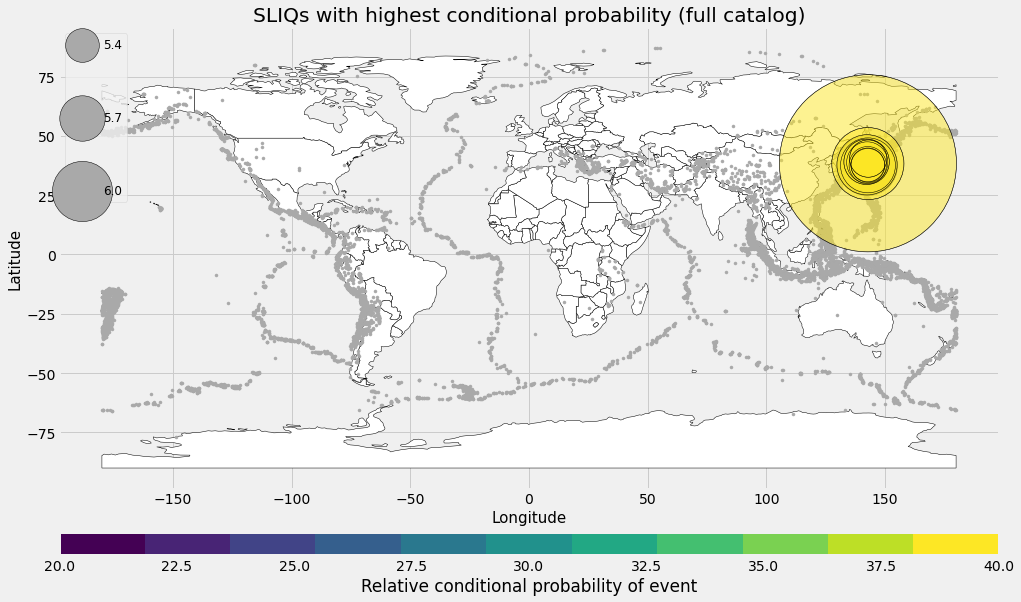

In [82]:
probability_map_cb(sliq_full.head(10),sliq_full.cp.head(10), [1,8,6],
                'SLIQs with highest conditional probability (full catalog)',20,40,11)

In [83]:
sliq_etas.head(10)

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,10468,28.8810,94.6260,2005-06-01 20:06:41.450,5.8,POINT (28.881 94.626),5.4,0.0,6.907373e-11,0.796710,0.203290,1.0,25.80,31.35207431117368,11.914214
1,11828,29.5730,95.6050,2003-08-18 09:03:03.520,5.5,POINT (29.573 95.605),5.4,0.0,6.907373e-11,0.585476,0.414524,1.0,33.00,31.84687742437117,11.914214
2,11864,22.8540,92.3060,2003-07-26 23:18:17.960,5.7,POINT (22.854 92.306),5.4,0.0,6.907373e-11,0.891394,0.108606,1.0,10.00,31.68322316970908,11.914214
3,3127,-1.0355,31.6181,2016-09-10 12:27:33.410,5.9,POINT (-1.0355 31.6181),5.4,0.0,6.907373e-11,0.470086,0.529914,1.0,40.00,45.98749350911166,9.359505
4,4412,40.3731,51.5739,2014-06-07 06:05:29.910,5.5,POINT (40.3731 51.5739),5.4,0.0,6.907373e-11,0.792073,0.207927,1.0,30.51,-43.05570164414012,7.904443
5,2489,29.8333,94.9838,2017-11-17 22:34:19.450,6.4,POINT (29.8333 94.9838),5.4,0.0,6.907373e-11,0.784964,0.215036,1.0,8.00,-34.524163515651196,3.926561
6,1414,41.3375,19.5303,2019-09-21 14:04:25.803,5.6,POINT (41.3375 19.5303),5.4,0.0,6.907373e-11,0.854188,0.145812,1.0,20.00,-31.47946384880278,3.372833
7,5135,60.2330,163.4000,2013-03-13 03:12:52.180,5.8,POINT (60.233 163.4),5.4,0.0,6.907373e-11,0.890949,0.109051,1.0,5.00,24.37659419529761,3.285261
8,211,29.1944,105.3650,2021-09-15 20:33:31.851,5.4,POINT (29.1944 105.365),5.4,0.0,6.907373e-11,0.890814,0.109186,1.0,7.12,24.034845793439793,3.285261
9,7699,41.4830,20.3880,2009-09-06 21:49:42.170,5.5,POINT (41.483 20.388),5.4,0.0,6.907373e-11,0.882697,0.117303,1.0,3.00,-16.324714766633,2.832101


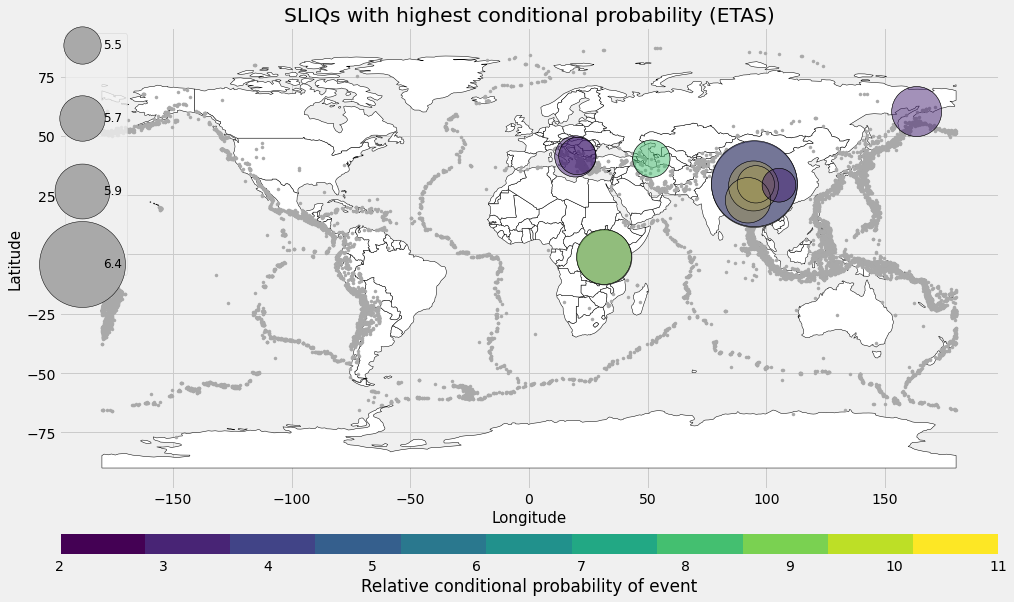

In [79]:
probability_map_cb(sliq_etas.head(10),sliq_etas.cp.head(10), [1,2,3,5],
                'SLIQs with highest conditional probability (ETAS)',2,11,11)

### Next, we examine the depth of a SLIQ compared to the depth of all events in the full catalog and ETAS declustered catalog.

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


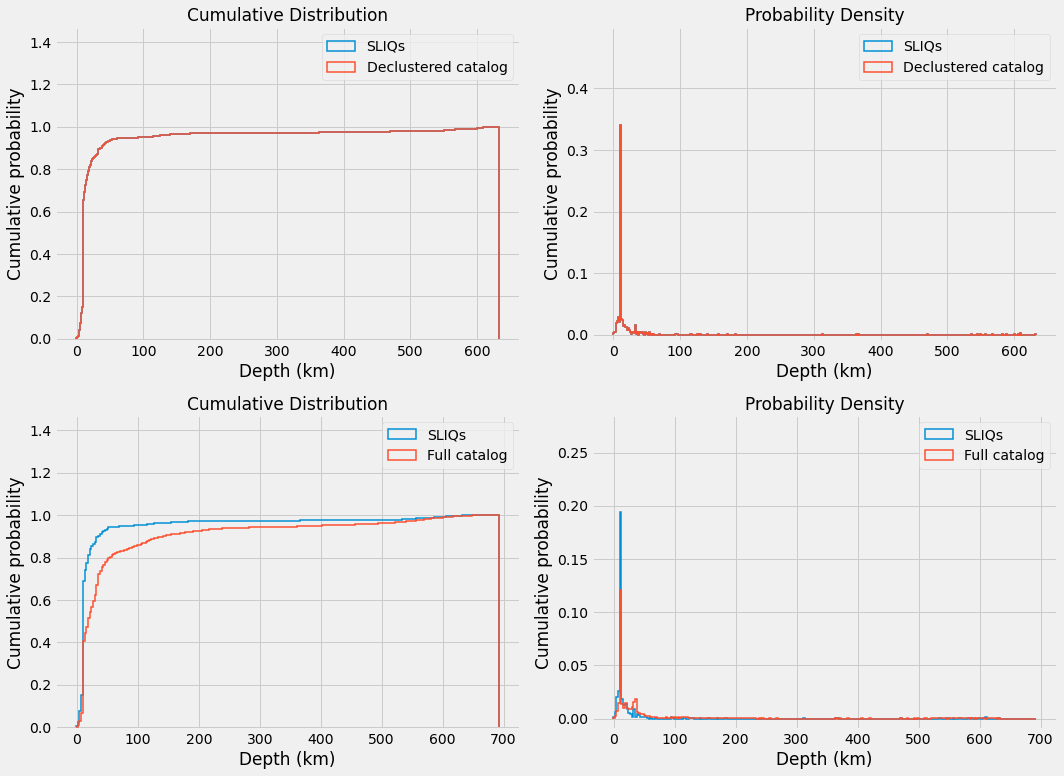

In [41]:
def depth_fig(ax,catalog,cumulative,label,title,sliq):

    bins_depth = loadquakes.calculate_bin_sizes(catalog.depth,'fd')

    ax.hist(sliq.depth,bins_depth,density = True,cumulative=cumulative, histtype='step',
            label='SLIQs',linewidth=1.5)
    ax.hist(catalog.depth, bins_depth,density = True, cumulative=cumulative,histtype='step',
            label=label,linewidth=1.5)
    yl = ax.get_ylim()
    ax.set_ylim((-0.01,1.4*yl[1]))
    xl = ax.get_xlim()
    ax.set_xlim(xl[0],xl[1])
    ax.legend()
    ax.set_xlabel('Depth (km)', fontsize = 17)
    ax.set_ylabel("Cumulative probability", fontsize = 17)
    ax.set_title(title, fontsize = 17)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,11))

depth_fig(ax1,etas_declustered,True,'Declustered catalog',"Cumulative Distribution",sliq_etas)
depth_fig(ax2,etas_declustered,False,'Declustered catalog','Probability Density',sliq_etas)
depth_fig(ax3,catalog,True,'Full catalog',"Cumulative Distribution",sliq_etas)
depth_fig(ax4,catalog,False,'Full catalog','Probability Density',sliq_etas)

fig.tight_layout()

### Depth statistics:

In [42]:
print('Catalog mean:   %f'%catalog['depth'].mean())
print('Catalog median:   %f'%catalog['depth'].median())

print('Declustered catalog mean:   %f'%etas_declustered['depth'].mean())
print('Declustered catalog median: %f'%etas_declustered['depth'].median())

print('SLIQ mean:   %f'%sliq_etas['depth'].mean())
print('SLIQ median:   %f'%sliq_etas['depth'].median())

Catalog mean:   63.111372
Catalog median:   20.000000
Declustered catalog mean:   31.788479
Declustered catalog median: 10.000000
SLIQ mean:   31.788479
SLIQ median:   10.000000


In [43]:
sliq_etas.to_csv('sliq_etas.csv', index=False)

## 7. Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [44]:
np.mean(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)

In [45]:
np.std(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(25.49255185)

In [46]:
random_load1 = np.random.normal(loc=-0.65387518, scale=25.49255185, size=(205, 360, 720))

In [47]:
ds_random = ds

In [48]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [49]:
# earthquake catalog

etas_declustered_random = catalog[catalog['P_triggered']<.9]

In [50]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
etas_declustered_random['dmass'] = etas_declustered_random.apply(lambda row: get_mass_random(row), axis=1)

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


18


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


18
17


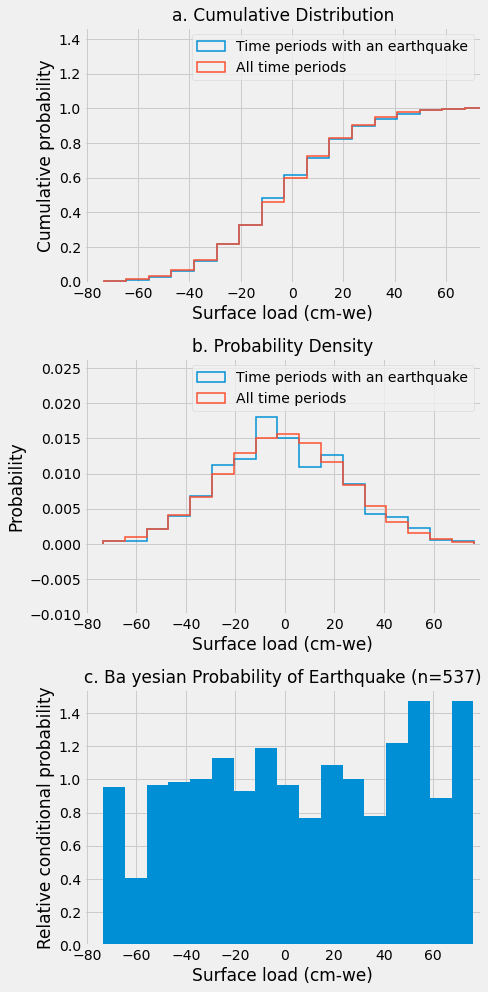

In [51]:
set_of_figures_load(ds_random['load'].data.flatten(), 
                    etas_declustered_random.dmass,'c. Ba yesian Probability of Earthquake (n=537)',
                    'fd')

In [52]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(etas_declustered_random.dmass),np.array(ds_random['load'].data.flatten()))

### Statistics:

- CramerVonMisesResult(statistic=0.17526630647677166, pvalue=0.3209730702334621),
- KstestResult(statistic=0.034015491711791634, pvalue=0.5517688029164669),
- 'median_all': -0.6580511187055076,
- 'median_eq': array(0.95553539),
- 'mean_all': -0.655453456680114,
- 'mean_eq': 0.04997674867629525,
- 'mean_all_minus_mean_eq': -0.7054302053564092,
- 'median_all_minus_median_eq': -1.6135865102031677}

## 8. Correlation between moderately clustered catalog (NND) and surface mass loading

In [53]:
NND_declustered_ind = pd.read_csv('NND_declustered_catalog.csv')
NND_declustered_ind = NND_declustered_ind.to_numpy()[:, -1]

In [54]:
NND_declustered = catalog.iloc[NND_declustered_ind]

In [55]:
# NND_declustered.to_csv('NND-catalog.csv')

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


376


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


376
375


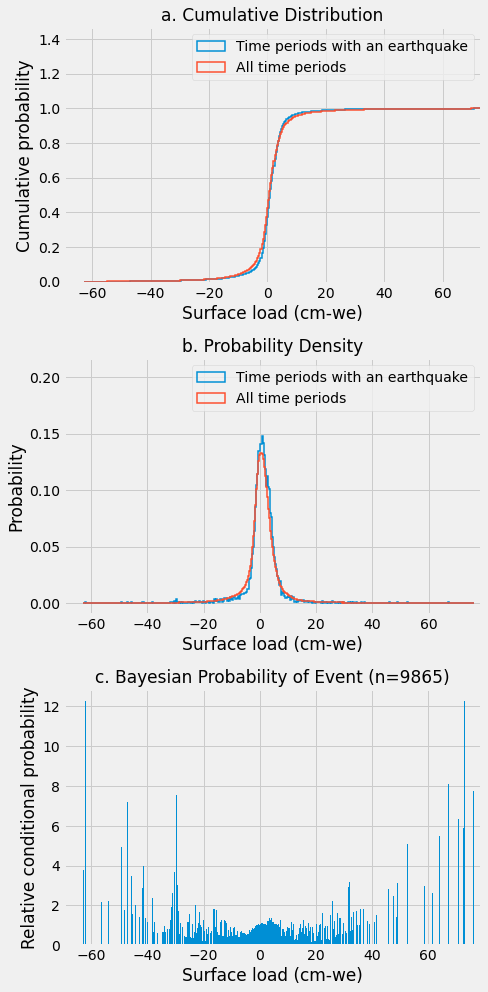

In [56]:
importlib.reload(loadquakes)

set_of_figures_load(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass,
                    'c. Bayesian Probability of Event (n=9865)','fd')

31
30


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


376
375


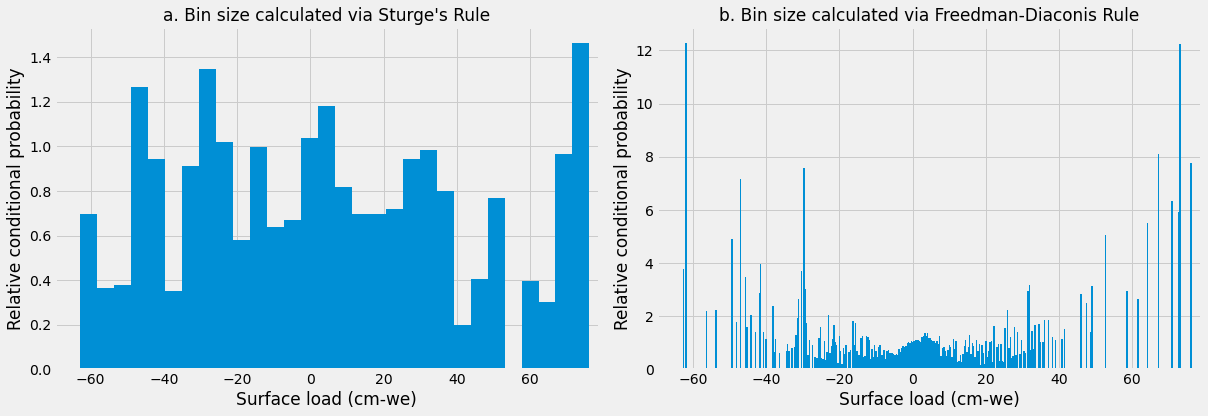

In [57]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method='Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), NND_declustered.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method='fd')

fig.tight_layout()


In [58]:
print('NND declustered mean:   %f'%NND_declustered['dmass'].mean())
print('NND declustered median: %f'%NND_declustered['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

NND declustered mean:   1.026598
NND declustered median: 1.046250
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


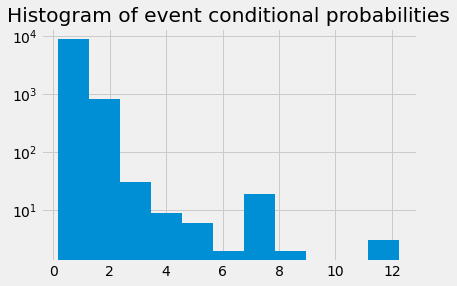

In [60]:
nnd_conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(NND_declustered.dmass), np.array(NND_declustered.dmass), 'fd')
NND_declustered['cp'] = nnd_conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(NND_declustered['cp']),11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

In [61]:
sliq_nnd=NND_declustered.sort_values('cp',ascending=False)
sliq_nnd=sliq_nnd.reset_index()
sliq_nnd=sliq_nnd.drop(['index'], axis=1)

sliq_nnd

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,6337,39.3680,141.8950,2011-04-12 19:37:48.290,5.6,POINT (39.368 141.895),5.4,0.0,6.907373e-11,0.999989,1.077595e-05,1.0,45.00,-61.94488949615575,12.266465
1,6361,39.3230,141.9500,2011-04-01 11:57:54.390,5.9,POINT (39.323 141.95),5.4,0.0,6.907373e-11,0.999988,1.236225e-05,1.0,41.00,-61.94488949615575,12.266465
2,2890,3.3168,98.4696,2017-01-16 12:42:10.680,5.6,POINT (3.3168 98.4696),5.4,0.0,6.907373e-11,0.984950,1.504972e-02,1.0,6.00,73.21784196242606,12.252366
3,1801,7.4036,94.3739,2019-01-17 02:53:06.400,5.4,POINT (7.4036 94.37390000000001),5.4,0.0,6.907373e-11,0.999257,7.434920e-04,1.0,88.00,67.04559907778497,8.087677
4,1665,7.4194,94.4056,2019-04-13 16:12:55.522,5.4,POINT (7.4194 94.40560000000001),5.4,0.0,6.907373e-11,0.999953,4.660506e-05,1.0,10.00,67.10871448635933,8.087677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9860,4216,23.3834,100.4702,2014-10-07 13:49:39.720,6.1,POINT (23.3834 100.4702),5.4,0.0,6.907373e-11,0.916108,8.389165e-02,1.0,8.51,22.068794358114943,0.268760
9861,3729,40.9329,47.5328,2015-09-04 04:49:38.520,5.4,POINT (40.9329 47.5328),5.4,0.0,6.907373e-11,0.981027,1.897288e-02,1.0,13.96,-20.384058704314988,0.226616
9862,8444,39.0270,140.8520,2008-06-14 00:20:47.670,5.4,POINT (39.027 140.852),5.4,0.0,6.907373e-11,1.000000,5.114617e-08,1.0,10.20,-19.094178708477152,0.214495
9863,7576,6.7290,-82.5790,2009-10-22 00:51:39.210,6.0,POINT (6.729 -82.57899999999999),5.4,0.0,6.907373e-11,0.999191,8.089458e-04,1.0,18.00,19.59277416907005,0.212808


In [64]:
sliq_nnd.head(10)

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,6337,39.3680,141.8950,2011-04-12 19:37:48.290,5.6,POINT (39.368 141.895),5.4,0.0,6.907373e-11,0.999989,0.000011,1.0,45.00,-61.94488949615575,12.266465
1,6361,39.3230,141.9500,2011-04-01 11:57:54.390,5.9,POINT (39.323 141.95),5.4,0.0,6.907373e-11,0.999988,0.000012,1.0,41.00,-61.94488949615575,12.266465
2,2890,3.3168,98.4696,2017-01-16 12:42:10.680,5.6,POINT (3.3168 98.4696),5.4,0.0,6.907373e-11,0.984950,0.015050,1.0,6.00,73.21784196242606,12.252366
3,1801,7.4036,94.3739,2019-01-17 02:53:06.400,5.4,POINT (7.4036 94.37390000000001),5.4,0.0,6.907373e-11,0.999257,0.000743,1.0,88.00,67.04559907778497,8.087677
4,1665,7.4194,94.4056,2019-04-13 16:12:55.522,5.4,POINT (7.4194 94.40560000000001),5.4,0.0,6.907373e-11,0.999953,0.000047,1.0,10.00,67.10871448635933,8.087677
5,2678,2.7455,98.9789,2017-07-11 01:24:32.110,5.4,POINT (2.7455 98.9789),5.4,0.0,6.907373e-11,0.998735,0.001265,1.0,146.54,76.05586119570916,7.769357
6,6362,38.9220,141.8210,2011-03-31 07:15:30.190,6.0,POINT (38.922 141.821),5.4,0.0,6.907373e-11,0.999990,0.000010,1.0,42.00,-29.597742889705952,7.571536
7,6373,38.7720,141.8800,2011-03-25 11:36:24.490,6.2,POINT (38.772 141.88),5.4,0.0,6.907373e-11,0.999989,0.000011,1.0,39.00,-29.597742889705952,7.571536
8,10621,5.4860,94.5950,2005-03-13 22:12:45.820,5.5,POINT (5.486 94.595),5.4,0.0,6.907373e-11,0.999978,0.000022,1.0,52.30,-29.463465397840523,7.571536
9,6435,38.8490,141.8580,2011-03-13 09:52:30.970,5.6,POINT (38.849 141.858),5.4,0.0,6.907373e-11,0.999995,0.000005,1.0,33.00,-29.597742889705952,7.571536


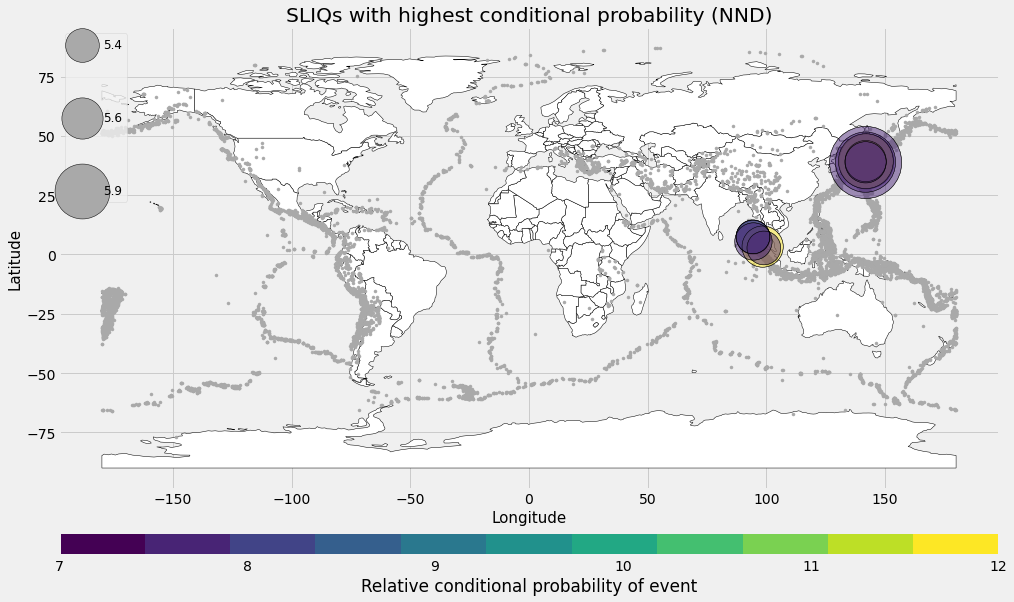

In [84]:
probability_map_cb(sliq_nnd.head(10),sliq_nnd.head(10).cp, [3,9,1],
                'SLIQs with highest conditional probability (NND)',7,12,11)

In [158]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(NND_declustered.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics:

- CramerVonMisesResult(statistic=15.77332981982454, pvalue=4.454382085405939e-09),
- KstestResult(statistic=0.06252798045367963, pvalue=5.755761429611317e-34),
- 'median_all': 0.749170696239575,
- 'median_eq': array(1.04625004),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 1.026597588716882,
- 'mean_all_minus_mean_eq': -1.680472767130602,
- 'median_all_minus_median_eq': -0.29707934497504307}

#  Things to do:
- (done)Use only Freedman-Diaconis. 
- (done) We don't use Sturge because large n -- write a line on this in paper
- (done) Remove ugly red line on all plots
- make 3 maps on one image? full/etas/nnd (only 10 biggest!)
- (done) make bayes probability hists for random data using FD!
- (done) run calc_stats for random data
- (done) upload all SLIQ catalogs to github
- add the right figs
- make appropriate mentions

- discuss bigger context with supplemental figures -- describe state of global surafce mass field (regional context): Gorkha happenned during period of unloading (non-monsoon season) associated with the pre-monsoon phase of the hydrological cycle. (unseasonably early mass anomaly) - most events actually happen in the summer in Nepal.
--> consistent with Bollinger! 

/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


402


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


402
401
376


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


376
375
71


/home/amand4/anaconda3/envs/syamsul_2023/lib/python3.7/site-packages/scipy/stats/stats.py:2838: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  np.VisibleDeprecationWarning


71
70


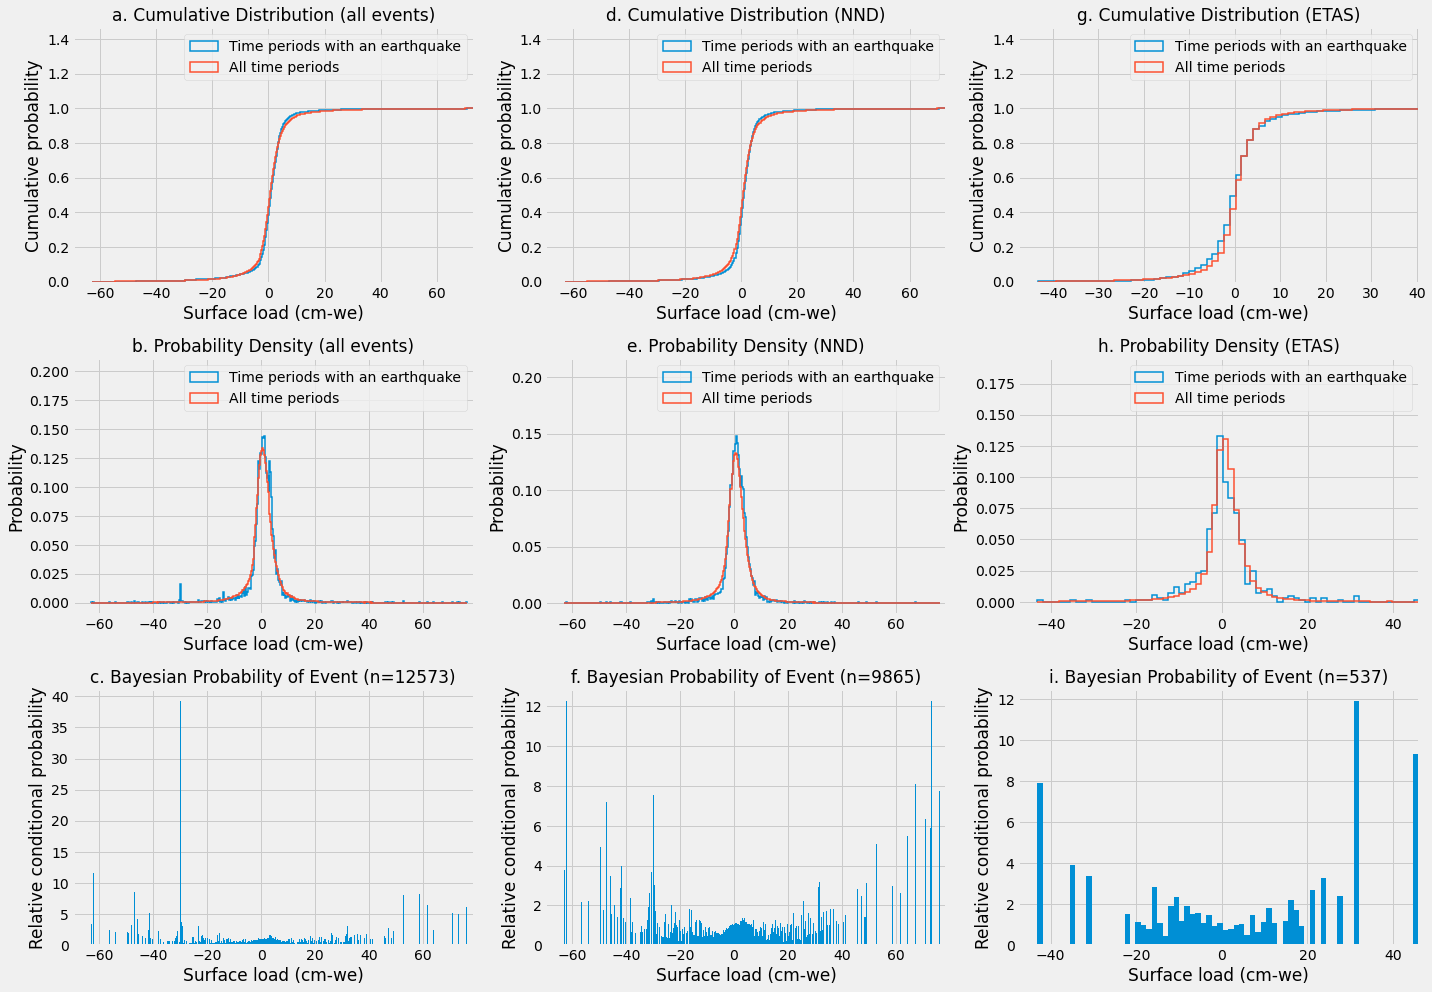

In [164]:
importlib.reload(loadquakes)

def all_figs(all_loads,full_catalog,etas_catalog,nnd_catalog,bayes_title1,bayes_title2,bayes_title3,method):

    fig,((ax1,ax4,ax7),(ax2,ax5,ax8),(ax3,ax6,ax9)) = plt.subplots(3,3, figsize=(20,14))

    plt.style.use('fivethirtyeight')
    
    # full catalog
    loadquakes.plot_hist(all_loads, full_catalog, ax1, ax2, 
              'a. Cumulative Distribution (all events)', 'b. Probability Density (all events)', method)

    loadquakes.plot_bayes(all_loads, full_catalog, ax3, bayes_title1,
                         method)
    
    # catalog declustered using NND method
    loadquakes.plot_hist(all_loads, nnd_catalog, ax4, ax5, 
              'd. Cumulative Distribution (NND)', 
                         'e. Probability Density (NND)',
                         method)

    loadquakes.plot_bayes(all_loads, nnd_catalog, ax6, bayes_title2,
                         method)
    
    # catalog declustered using ETAS method
    loadquakes.plot_hist(all_loads, etas_catalog, ax7, ax8, 
              'g. Cumulative Distribution (ETAS)',
                         'h. Probability Density (ETAS)',
                         method)

    loadquakes.plot_bayes(all_loads, etas_catalog, ax9, bayes_title3,
                         method)
    fig.tight_layout()
    
all_figs(ds['lwe_thickness'].data.flatten(),
         catalog.dmass,
         etas_declustered.dmass,
         NND_declustered.dmass,
         'c. Bayesian Probability of Event (n=12573)',
         'f. Bayesian Probability of Event (n=9865)',
         'i. Bayesian Probability of Event (n=537)',
         'fd')

In [2]:
catalog

NameError: name 'catalog' is not defined